In [1]:
# basic packages
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn

#Shared/Utility scripts
import sys
sys.path.insert(0, '../..') #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Simple_Eval, dataloader, mlp_dataprocessing, mlp_model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HOME = os.path.expanduser('~')


modelname = 'MLP'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"
print(f"{modelname} development script")

Device: cuda
Device: cuda
MLP development script


In [2]:
modelname = 'MLP'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"

cfsday_AFday = 1.983

#input columns
input_columns =[
                'Lat', 
                'Long', 
                'Drainage_area_mi2', 
                'Mean_Basin_Elev_ft',       
                'Perc_Forest', 
                'Perc_Develop', 
                'Perc_Imperv', 
                'Perc_Herbace',       
                'Perc_Slop_30', 
                'Mean_Ann_Precip_in', 
                's1',       
                's2', 
                'storage', 
                'swe', 
                'NWM_flow', 
                'DOY', 
                'tempe(F)', 
                'precip(mm)'
                ]

target = 'flow_cfs'

test_years = [2019, 2020]                 

#load data
datapath = f"{HOME}/NWM_ML/Data/input"
trainingfile = "final_input.parquet"

df, StreamStats = dataloader.get_ML_Data(datapath, trainingfile)
df.head()

df needs no processing


,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY,tempe(F),precip(mm)
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301,39.239582,0.0
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302,45.068712,0.0
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303,50.945891,0.0
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304,45.480097,0.0
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305,46.656777,0.0


### Dataprocessing
* Editing the features based on the feature importance
* Remove headwater stations from dataset
* make sure dates are in datetime format

In [3]:
#get non headwater stations
headwater_stations = ['10011500', # Bear River headwaters before WY state line
                      '10109000', # Logan River above dams
                      '10113500', # HW Blacksmith fork
                      '10128500', # Upper Weber above Oakley
                      '10131000', #Chalk creek before Weber - lots of upstream irrigation, potentially include
                        '10146400', #Currant Creek above Mona Reservoir - lots of upstream irrigation, potentially include
                        '10150500', #Spanish fork after diamond fork - potentially include because of 6th water diversion CUP
                        '10154200', #Upper Provo river after confluence of N/S forks - potentially include because of duchense tunnel water diversion CUP
                        '10172700', #Vernon creek 2 ranges west of Utah Lake, shouldnt be included because not in GSL basin 
                        '10172800', #Willow creek west of Gransville,  shouldnt be included because does not make it to GSL
                          '10172952'
                          ] #Dunn creek in Raft River Range, shouldnt be included because drains to bonnevile salt flats 

#remove headwater stations
df = df[~df['station_id'].isin(headwater_stations)]

#get stations with correct swe and storage features
#The following sites have swe 

'''
['10011500', '10105900', '10109000', '10126000', '10131000',
       '10133650', '10133800', '10133980', '10134500', '10136500',
       '10140700', '10141000', '10150500', '10154200', '10155000',
       '10155200']
'''

#the following sites have swe and storage
'''
['10126000', '10134500', '10136500', '10140700', '10141000',
       '10155200']
'''

stations = df['station_id'][(df['swe']>0) & (df['storage']>0)].unique()

#Train model with these stations
df = df[df['station_id'].isin(stations)]

#convert dates to datetime format
df.datetime = pd.to_datetime(df.datetime)

# #reset index to clean up df
df.reset_index( inplace =  True, drop = True)

#fit a scaler,save, and scale the training data
x_train_scaled, y_scaled_train = mlp_dataprocessing.mlp_scaler(
                                                      df,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      scalertype = 'MinMax'
                                                      )

x_test_scaled, y_test_temp, x_test_temp, station_index_list = mlp_dataprocessing.mlp_testscaler(
                                                      df,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      )

# Convert to tensor for PyTorch
x_train_scaled_t = torch.Tensor(x_train_scaled)
y_train_scaled_t = torch.Tensor(y_scaled_train)
#Make sure the tensors on are the respective device (cpu/gpu)
x_train_scaled_t = x_train_scaled_t.to(device)
y_train_scaled_t = y_train_scaled_t.to(device)

(26089, 1)
(26089, 18)
(3834, 18)


### Set up Testing year
* Select year(s) not used in training
* Convert to numpy array
* Load scaler and scale data

## Train the model

* randomize training data..
* add training loss https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

## Loss functions

### Mean Absolute Error (MAE)
Regression problems, especially when the distribution of the target variable has outliers, such as small or big values that are a great distance from the mean value.
It is considered to be more robust to outliers.
PyTorch implementation as **nn.L1Loss()**

### Mean Squared Error (MSE)
The MSE, also called L2 Loss, computes the average of the squared differences between actual values and predicted values.
Pytorch MSE Loss always outputs a positive result, regardless of the sign of actual and predicted values. 
To enhance the accuracy of the model, you should try to reduce the L2 Loss—a perfect value is 0.0. 

The squaring implies that larger mistakes produce even larger errors than smaller ones. 
If the classifier is off by 100, the error is 10,000. If it’s off by 0.1, the error is 0.01. This punishes the model for making big mistakes and encourages small mistakes. 

MSE is the default loss function for most Pytorch regression problems.

### Make your own loss function
https://neptune.ai/blog/pytorch-loss-functions

In [8]:
epochs = [60] # - seems to converge around 80 epochs with 100 batrch size
batch_size = [60]
learning_rate = [0.0001]  #look up learning rate scheduler https://www.geeksforgeeks.org/understanding-pytorch-learning-rate-scheduling/ -  smaller learning rates doing better!
decay = [0.0005]
L1 = [60, 120]
L2 = [60, 120]
L3 = [30, 60]
L4 = [30, 60]
L5 = [15,30]
L6 = [10,20]

search_params = epochs, batch_size, learning_rate, decay, L1, L2, L3, L4, L5, L6
loss_func = nn.MSELoss()
supply = False


GS_Eval_DF, GS_Eval_dict = mlp_model.mlp_optimization(search_params, 
                     x_train_scaled_t, 
                     y_train_scaled_t, 
                     loss_func, 
                     model_path, 
                     modelname, 
                     supply, 
                     test_years, 
                     stations,                                                               
                     x_test_temp,
                     x_test_scaled, 
                     y_test_temp,
                     StreamStats,
                     station_index_list)
GS_Eval_DF

Optimizing the MLP model by evaluating 64 models using grid search validation
Training 1 of 64 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 60, 60, 30, 30, 15, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.25841546058655 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.49,236.0,242.0,221.61,193.25,-30.30,-18.85
10155200,0.63,0.40,192.0,229.0,29.28,67.44,15.23,-16.70
10136500,-0.42,0.27,644.0,404.0,330.76,197.40,-137.08,-68.05
10134500,-0.97,0.22,132.0,56.0,545.15,274.06,-173.33,-70.38
10126000,-0.31,0.16,1716.0,1197.0,306.30,211.45,-39.65,-62.09
10141000,-2.10,0.10,1169.0,457.0,1111.22,304.32,-304.72,-87.30


Training 2 of 64 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 60, 60, 30, 30, 15, 20)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.24746656417847 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.62,132.0,38.0,545.15,134.29,-173.33,-20.55
10136500,-0.42,0.50,644.0,343.0,330.76,153.95,-137.08,-42.10
10140700,0.29,0.48,236.0,235.0,221.61,139.62,-30.30,2.23
10141000,-2.10,0.38,1169.0,386.0,1111.22,241.95,-304.72,-58.13
10155200,0.63,0.38,192.0,231.0,29.28,55.21,15.23,-1.99
10126000,-0.31,0.20,1716.0,1144.0,306.30,199.06,-39.65,-53.83


Training 3 of 64 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 60, 60, 30, 30, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

In [6]:
GS_Eval_DF

,MLP_flow_kge,MLP_flow_rmse,MLP_flow_mape,MLP_flow_pbias,Epochs,Batchsize,LR,Decay,L1,L2,L3,L4,L5,L6
0,0.416667,397.333333,154.020000,-28.428333,60,60,0.00010,0.00050,128,128,64,64,32,16
0,0.313333,436.666667,142.520000,-44.468333,60,60,0.00010,0.00005,128,128,64,64,32,16
0,0.270000,357.833333,184.916667,-15.118333,60,60,0.00001,0.00050,128,128,64,64,32,16
0,0.206667,456.666667,226.766667,-64.613333,60,60,0.00001,0.00005,128,128,64,64,32,16
0,0.438333,388.833333,142.970000,-20.778333,60,75,0.00010,0.00050,128,128,64,64,32,16
0,0.345000,423.000000,137.921667,-40.231667,60,75,0.00010,0.00005,128,128,64,64,32,16
0,0.258333,358.500000,182.696667,-13.381667,60,75,0.00001,0.00050,128,128,64,64,32,16
0,0.191667,458.500000,236.643333,-66.275000,60,75,0.00001,0.00005,128,128,64,64,32,16
0,0.445000,386.500000,139.898333,-18.611667,60,90,0.00010,0.00050,128,128,64,64,32,16
0,0.358333,418.166667,134.780000,-38.608333,60,90,0.00010,0.00005,128,128,64,64,32,16


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.37676644325256 seconds 
USGS site: 10126000


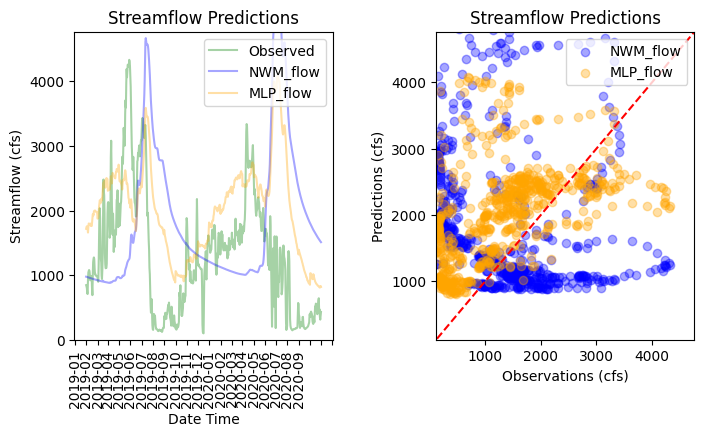

USGS site: 10134500


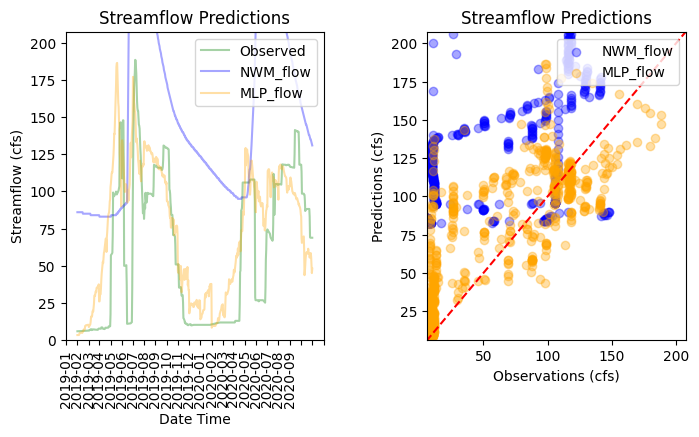

USGS site: 10136500


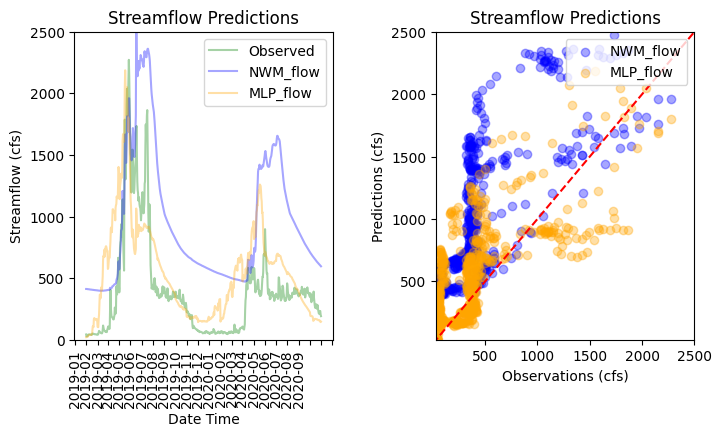

USGS site: 10140700


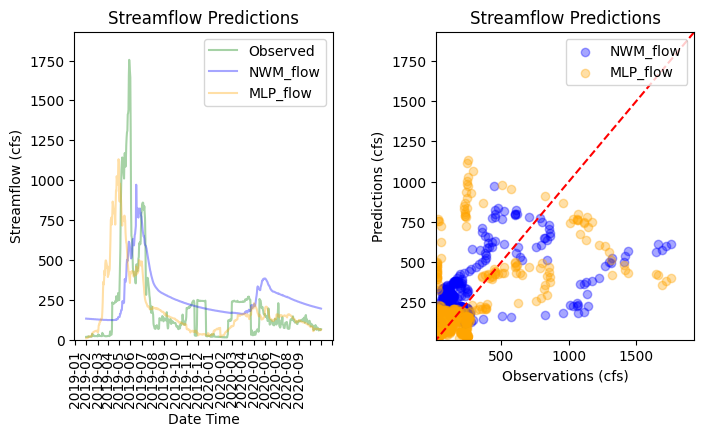

USGS site: 10141000


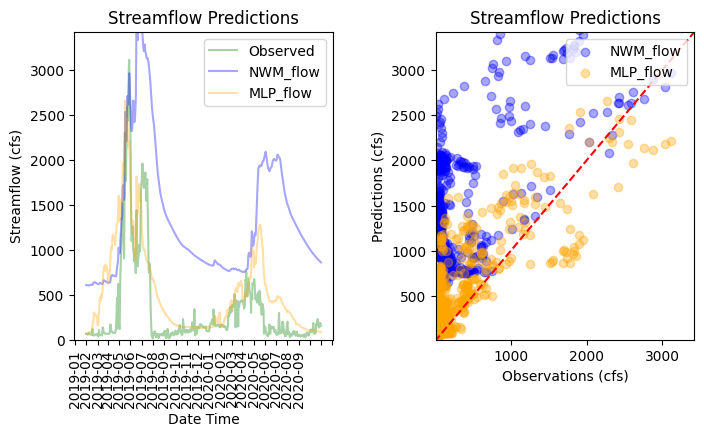

USGS site: 10155200


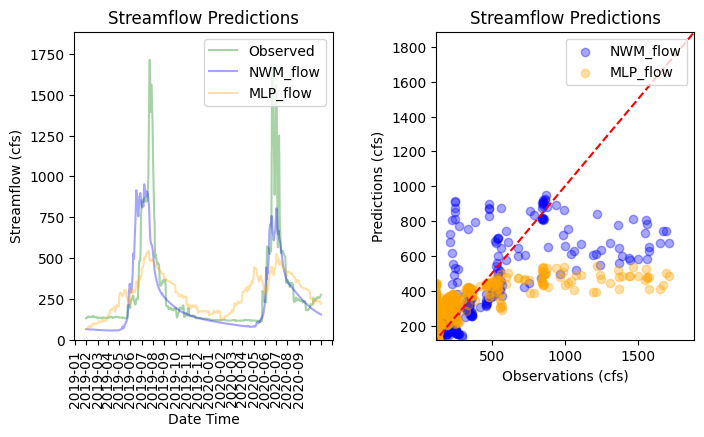

,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.65,132.0,35.0,545.15,128.68,-173.33,-23.79
10136500,-0.42,0.50,644.0,347.0,330.76,157.34,-137.08,-40.09
10140700,0.29,0.47,236.0,243.0,221.61,138.25,-30.30,2.50
10141000,-2.10,0.36,1169.0,392.0,1111.22,252.52,-304.72,-59.52
10155200,0.63,0.30,192.0,240.0,29.28,54.20,15.23,1.69
10126000,-0.31,0.22,1716.0,1127.0,306.30,193.13,-39.65,-51.36


In [5]:
Eval_DF, Preds_Dict = mlp_model.Final_Model(GS_Eval_DF,
                x_train_scaled_t,
                y_train_scaled_t, 
                loss_func, 
                model_path, 
                modelname,
                test_years, 
                stations, 
                x_test_temp,
                x_test_scaled, 
                y_test_temp,
                StreamStats,
                station_index_list)
Eval_DF

## Code to manually train a model

In [ ]:
#Train the model with optimized parameters
# parameters
epochs = 75 # - seems to converge around 80 epochs with 100 batrch size
batch_size = 100
learning_rate = 0.0001  #look up learning rate scheduler https://www.geeksforgeeks.org/understanding-pytorch-learning-rate-scheduling/ -  smaller learning rates doing better!
decay = 0.0005
L1 = 128
L2 = 128
L3 = 64
L4 = 64
L5 = 32
L6 = 16
layers = x_train_scaled_t.shape[1], L1, L2, L3, L4, L5, L6
params =  learning_rate, decay, epochs, batch_size
loss_func = nn.MSELoss()

#Train the model
mlp_model.mlp_train(x_train_scaled_t,
                    y_train_scaled_t, 
                    layers, params, 
                    loss_func, 
                    model_path, 
                    modelname, 
                    shuffle = True)


#Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
Preds_Dict = mlp_model.mlp_predict(test_years, 
                      layers, 
                      model_path, 
                      modelname, 
                      stations, 
                      x_test_temp,
                      x_test_scaled, 
                      y_test_temp,
                      StreamStats,
                      station_index_list)

#Evaluate model performance of the different models, 'flow_cfs_pred', 
prediction_columns = ['NWM_flow', f"{modelname}_flow"]
Eval_DF = Simple_Eval.Simple_Eval(Preds_Dict, 
                                  prediction_columns, 
                                  modelname, 
                                  supply = False,
                                  plots = False, 
                                  keystats = False        
                                  )
Eval_DF

